In [1]:
import sys
sys.path.append("../scripts")

import re
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from dataset_config import label_names_dict

save_dir = "../plots/notebook_plots/model_goodness_of_fit/"

In [2]:
def load_gp_data(path, name):
    
    with open(path) as f:
        gp_df = pd.read_json(f)
        gp_df['model'] = name
        
    return gp_df

def load_gpar_data(path, name, matrix_factorized=False):
    
    with open(path) as f:
        gpar_data = pd.read_json(f)
        
        dfs = []
        for i, row in gpar_data.iterrows():
            items = {
                'model': name + (("_" + str(row["latent_size"])) if matrix_factorized else ""),
                'index': row['index'],
                'output': row['outputs'],
                'size': row["size"],
#                 "train_time": row["train_time"],
#                 "predict_time": row["predict_time"],
                "rmse": row["rmse"],
                "mean_abs_err": row["mean_abs_err"],
                "mean_squ_err": row["mean_squ_err"],
            } 
            if "input_transformed" in row:
                items["transforms_used"] = f'{("input" if row["input_transformed"] else "")}_' \
                                           f'{("output" if row["output_transformed"] else "")}'
            
            df = pd.DataFrame(items)
            
            dfs.append(df)
        
    return pd.concat(dfs, axis=0, ignore_index=True)

In [3]:
def plot_stats(aggregate, stat: str):
    line_style_dict = {
        "gp": "solid",
        "gpar": "dashed",
        "gp_aux": "dotted",
        "mf_gpar_2": "dashdot",
        "mf_gpar_5": "dashdot",
        "mf_gpar_8": "dashdot"
    }
    
    line_color_dict = {
        "gp": "black",
        "gpar": "black",
        "gp_aux": "black",
        "mf_gpar_2": "red",
        "mf_gpar_5": "green",
        "mf_gpar_8": "blue",
    }
    
    model_label = {
        "gp": "GP",
        "gpar": "GPAR",
        "gp_aux": "GP-aux",
        "mf_gpar_2": "MF-GPAR (2)",
        "mf_gpar_5": "MF-GPAR (5)",
        "mf_gpar_8": "MF-GPAR (8)"
    }
    
    outputs = ["avg_power", "cycle", "total_area"]#, "total_energy", "total_time"]
    
    fig, axes = plt.subplots(nrows=1, ncols=len(outputs), figsize=(4 * len(outputs), 4))
    
    # Plot the outputs of interest
    for output, group in aggregate.groupby('output'):
        
        if output not in outputs: 
            continue
            
        ax = axes[outputs.index(output)]
        
        # Plot each model's performance on the current output
        for model, subgroup in group.groupby('model'):
            
            if model not in line_style_dict.keys(): 
                continue
                
            d = subgroup.sort_values("size")
            
            # Interpolated plot of performance
            ax.plot(d["size"],
                    d[(stat, 'mean')],
                    label=model_label[model],
                   c=line_color_dict[model],
                   linestyle=line_style_dict[model],
                   zorder=-1)
            
            # Plot actual points
            ax.scatter(d['size'],
                      d[(stat, 'mean')],
                      s=30,
                      c="white",
                      edgecolors='black',
                      zorder=1,
                      label=None)
            
            # Plot error bars
            ax.errorbar(d['size'],
                       d[(stat, 'mean')],
                       yerr=d[(stat, 'std')],
                       ecolor=line_color_dict[model],
                       fmt='None',
                       capsize=3,
                       zorder=-1,
                       label=None)
            
            ax.set_xlim([15, 210])
            
            ax.set_ylabel('MAE '+ label_names_dict[output], fontsize=12)
            ax.set_xlabel('Dataset Size', fontsize=12)
            
        ax.legend()
        
    fig.tight_layout()
    return fig

In [4]:
def comparison_plots(old_stats, new_stats, old_model: str, new_model: str, stat: str):
    line_style_dict = {
        "gp": "solid",
        "gpar": "dashed",
        "gp_aux": "dotted",
        "mf_gpar_2": "dashdot",
        "mf_gpar_5": "dashdot",
        "mf_gpar_8": "dashdot",
    }
    
    model_label = {
        "gp": "GP",
        "gpar": "GPAR",
        "gp_aux": "GP-aux",
        "mf_gpar_2": "MF-GPAR (2)",
        "mf_gpar_5": "MF-GPAR (5)",
        "mf_gpar_8": "MF-GPAR (8)"
    }
    
    old_df = old_stats[old_stats.model == old_model]
    new_df = new_stats[new_stats.model == new_model]
    
    outputs = ["avg_power", "cycle", "total_area"]
    
    old_df = old_df[old_df["output"].isin(outputs)]
    new_df = new_df[new_df["output"].isin(outputs)]
    
    fig, axes = plt.subplots(nrows=1, ncols=len(outputs), figsize=(4 * len(outputs), 4))
    
    fig.suptitle(f"Old {model_label[old_model]} - New {model_label[new_model]} performance comparison")
    
    # Plot the outputs of interest
    for (old_output, old_group), (new_output, new_group) in zip(old_df.groupby('output'), new_df.groupby('output')):
        
        print(old_output, new_output)
        
        if old_output not in outputs or new_output not in outputs: 
            continue
            
        ax = axes[outputs.index(old_output)]
        
        #-------------------------------------------
        # plot old stuff
        #-------------------------------------------
        d = old_group.sort_values("size")

        # Interpolated plot of performance
        ax.plot(d["size"],
                d[(stat, 'mean')],
                label=f"Old {model_label[old_model]}",
               c="black",
               linestyle=line_style_dict[old_model],
               zorder=-1)

        # Plot actual points
        ax.scatter(d['size'],
                  d[(stat, 'mean')],
                  s=30,
                  c="white",
                  edgecolors='black',
                  zorder=1,
                  label=None)

        # Plot error bars
        ax.errorbar(d['size'],
                   d[(stat, 'mean')],
                   yerr=d[(stat, 'std')],
                   ecolor='black',
                   fmt='None',
                   capsize=3,
                   zorder=-1,
                   label=None)

        #-------------------------------------------
        # plot new stuff
        #-------------------------------------------
        d = new_group.sort_values("size")

        # Interpolated plot of performance
        ax.plot(d["size"],
                d[(stat, 'mean')],
                label=f"New {model_label[new_model]}",
               c="red",
               linestyle=line_style_dict[new_model],
               zorder=-1)

        # Plot actual points
        ax.scatter(d['size'],
                  d[(stat, 'mean')],
                  s=30,
                  c="white",
                  edgecolors='black',
                  zorder=1,
                  label=None)

        # Plot error bars
        ax.errorbar(d['size'],
                   d[(stat, 'mean')],
                   yerr=d[(stat, 'std')],
                   ecolor='black',
                   fmt='None',
                   capsize=3,
                   zorder=-1,
                   label=None)
        
        ax.set_xlim([15, 210])

        ax.set_ylabel('MAE '+ label_names_dict[old_output], fontsize=12)
        ax.set_xlabel('Dataset Size', fontsize=12)
            
        ax.legend()
        
    fig.tight_layout()
    fig.subplots_adjust(wspace=0.5, top=0.9)

    return fig   

In [5]:
old_data_path = {
    "fft": "../../old-boa-data/data/fft/pred",
    "stencil3d": "../../old-boa-data/data/stencil3d/pred"
}

new_data_path = {
    "fft": "../logs/fft/pred",
    "stencil3d": "../logs/stencil3d/pred",
    "gemm": "../logs/gemm/pred",
    "smaug": "../logs/smaug/pred",
}

old_ff_gp_file = "gp_runs.json"
old_ff_gp_aux_file = "gp_aux_runs.json"
old_gpar_file = "gpar_runs.json"
old_mf_gpar_file = "mf_gpar_runs.json"

ff_gp_file = "ff-gp_experiments.json"
ff_gp_aux_file = "ff-gp-aux_experiments.json"
gpar_file = "gpar_experiments.json"
mf_gpar_2_file = "mf-gpar-2_experiments.json"
mf_gpar_5_file = "mf-gpar-5_experiments.json"
mf_gpar_8_file = "mf-gpar-8_experiments.json"

In [6]:
experiment_files = {
    "fft": {
        "old": [("gp", old_ff_gp_file),
                ("gp_aux", old_ff_gp_aux_file),
                ("gpar", old_gpar_file),
                ("mf_gpar", old_mf_gpar_file)
        ],
        "new": [#("gp", ff_gp_file),
                #("gpar", "20200311-154358/" + gpar_file),
                #("gpar", "20200311-160028/" + gpar_file),
                ("gpar", "20200311-165608/" + gpar_file),
                #("mf_gpar", mf_gpar_2_file), 
#                 ("mf_gpar", mf_gpar_5_file), 
#                 ("mf_gpar", mf_gpar_8_file)
        ],
        "comparisons": [#("gp", "gp"),
                        ("gpar", "gpar"),
                        #("mf_gpar_5", "mf_gpar_5")
        ]
    },
#     "stencil3d": {
#         "old": [("gp", old_ff_gp_file),
#                 ("gp_aux", old_ff_gp_aux_file),
#                 ("gpar", old_gpar_file),
#                 ("mf_gpar", old_mf_gpar_file)
#         ],
#         "new": [("gp", ff_gp_file),
#                 ("gpar", gpar_file),
#                 ("mf_gpar", mf_gpar_5_file), 
#         ],
#         "comparisons": [("gp", "gp"),
#                         ("gpar", "gpar"),
#                         ("mf_gpar_5", "mf_gpar_5")
#         ]
#     },
#     "gemm": {
#         "new": [("gp", ff_gp_file),
#                 ("gpar", gpar_file),
#                 ("mf_gpar", mf_gpar_5_file), 
#         ],
#     },
#     "smaug": {
#         "new": [
#             ("mf_gpar", mf_gpar_5_file)
#         ]
#     }
}

In [7]:
# Load the experiments data

experiment_data = {}

for task, task_dict in experiment_files.items():
    
    data_dict = {}
    
    # Load in stuff from BOA v0.2
    if "old" in task_dict:
        
        dataframes = []
        
        for name, file in task_dict["old"]:
            # If we need to load an old FF-GP dataset
            if name in ["gp", "gp_aux"]:
                dataframe = load_gp_data(os.path.join(old_data_path[task], file), name=name)
                dataframes.append(dataframe)
            else:
                dataframe = load_gpar_data(os.path.join(old_data_path[task], file), 
                                           name=name,
                                           matrix_factorized = name == "mf_gpar")
                dataframes.append(dataframe)
                
        data_dict["old"] = dataframes
        
    if "new" in task_dict:
        
        dataframes = []
        
        for name, file in task_dict["new"]:
            dataframe = load_gpar_data(os.path.join(new_data_path[task], name, file), 
                                       name=name,
                                       matrix_factorized = name == "mf_gpar")
            dataframes.append(dataframe)
                
        data_dict["new"] = dataframes
        
    if "comparisons" in task_dict:
        data_dict["comparisons"] = task_dict["comparisons"]
        
    experiment_data[task] = data_dict

Plotting for fft task
Plotting relative comparisons
avg_power avg_power
cycle cycle
total_area total_area


/scratch/gf332/BayesOpt/tf2-boa-venv/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


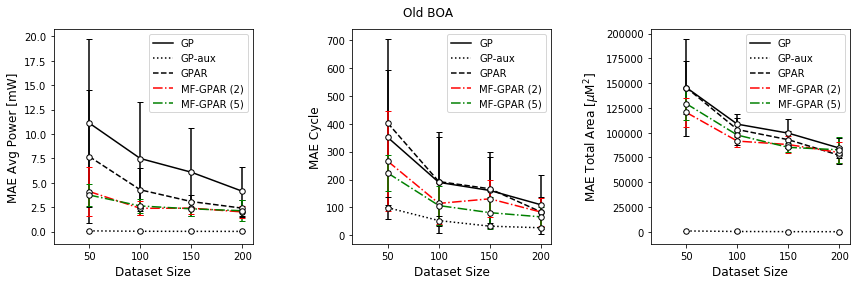

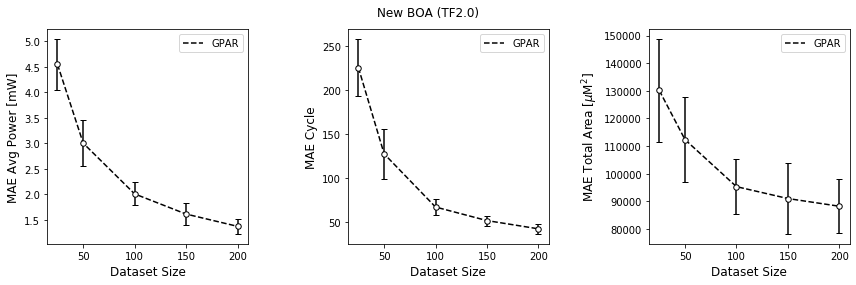

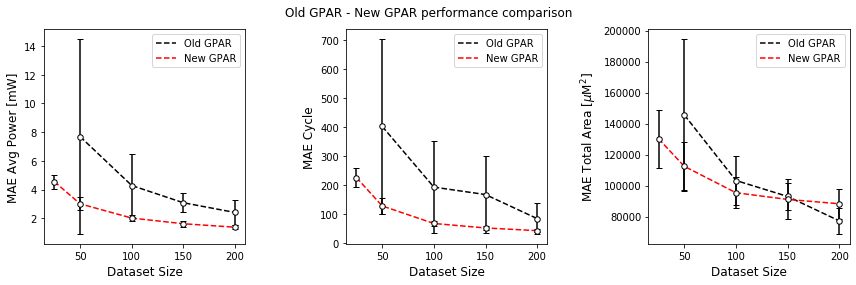

In [127]:
# Model comparison plots
for task, task_dict in experiment_data.items():
        
    task_save_dir = save_dir + f"/{task}"
    
    if not os.path.exists(task_save_dir):
        os.makedirs(task_save_dir)
        
    print(f"Plotting for {task} task")
    
    if "old" in task_dict:
        # Aggregate the stuff we want to plot
        # Old stuff
        old_aggregated = pd.concat(task_dict["old"], 
                                   sort=False, axis=0, ignore_index=True)

        old_stats = old_aggregated.groupby(['model', 'output', 'size'])
        old_stats = old_stats.aggregate({"mean_abs_err": [np.mean, np.std]}).reset_index()
        
        # Plot the data
        old_fig = plot_stats(old_stats, stat="mean_abs_err")
        old_fig.suptitle("Old BOA")
        old_fig.subplots_adjust(wspace=0.5, top=0.9)
        
        old_fig.savefig(task_save_dir + f"/old.png")
        
    if "new" in task_dict:
        # New data
        aggregated = pd.concat(task_dict["new"], 
                               sort=False, axis=0, ignore_index=True)

        stats = aggregated.groupby(['model', 'output', 'size'])
        stats = stats.aggregate({"mean_abs_err": [np.mean, np.std]}).reset_index()
        
        fig = plot_stats(stats, stat="mean_abs_err")
        fig.suptitle("New BOA (TF2.0)")
        fig.subplots_adjust(wspace=0.5, top=0.9)
        
        fig.savefig(task_save_dir + f"/new.png")
        
    print("Plotting relative comparisons")
    if "new" in task_dict and "old" in task_dict and "comparisons" in task_dict:
        
        for old_model, new_model in task_dict["comparisons"]:
            comp_fig = comparison_plots(old_stats, 
                                         stats, 
                                         old_model=old_model, 
                                         new_model=new_model, stat="mean_abs_err")
            
            comp_fig.savefig(task_save_dir + f"/comparison_old_{old_model}_new_{new_model}.png")
            comp_fig.show()
        
        
    plt.show()

In [319]:
!ls ../../old-boa-data/data/stencil3d/pred/

gpar_runs.json	gp_aux_runs.json  gp_runs.json	mf_gpar_runs.json


In [8]:
def read_model_statistics(model_dict):
    dfs = []

    for name, path in model_dict.items():
        with open(path) as f:
            gpar_data = pd.read_json(f)

            for i, row in gpar_data.iterrows():
                items = {
                    'model': name,
                    'index': row['index'],
                    'output': row['outputs'],
                    'size': row["size"],
        #                 "train_time": row["train_time"],
        #                 "predict_time": row["predict_time"],
                    "rmse": row["rmse"],
                    "mean_abs_err": row["mean_abs_err"],
                    "mean_squ_err": row["mean_squ_err"],
                } 
                if "input_transformed" in row:
                    items["transforms_used"] = f'{("input" if row["input_transformed"] else "")}_' \
                                               f'{("output" if row["output_transformed"] else "")}'

                if "std_mean_squ_err" in row:
                    items["std_mean_squ_err"] = row["std_mean_squ_err"]
                    items["std_mean_abs_err"] = row["std_mean_abs_err"]

                if "mean_predictive_variance" in row:
                    items["mean_predictive_variance"] = row["mean_predictive_variance"]
                    items["mean_predictive_std"] = row["mean_predictive_std"]

                df = pd.DataFrame(items)

                dfs.append(df)

    aggregated_df = pd.concat(dfs, axis=0, ignore_index=True)
    stats = aggregated_df.groupby(['model', 'output', 'size'])
    stats = stats.aggregate({"rmse": [np.mean, np.std],
                             "mean_abs_err": [np.mean, np.std],
                             "std_mean_abs_err": [np.mean, np.std],
                             "std_mean_squ_err": [np.mean, np.std],
                             "mean_predictive_variance": [np.mean, np.std],
                             "mean_predictive_std": [np.mean, np.std],
                            }).reset_index()
    
    return stats

In [9]:
def plot_model_stats(stats, task, save_name, outputs, sizes=None):

    line_style_dict = {
        "gp": "solid",
        "gpar": "dashed",
        "gp_aux": "dotted",
        "mf_gpar_2": "dashdot",
        "mf_gpar_5": "dashdot",
        "mf_gpar_8": "dashdot",
    }

    model_label = {
        "gp": "GP",
        "gpar": "GPAR",
        "gp_aux": "GP-aux",
        "mf_gpar_2": "MF-GPAR (2)",
        "mf_gpar_5": "MF-GPAR (5)",
        "mf_gpar_8": "MF-GPAR (8)"
    }

    stat_names = {
        "rmse": "RMSE",
        "mean_abs_err": "MAE", 
        "std_mean_abs_err": "SMAE", 
        "std_mean_squ_err": "SMSE",
        "mean_predictive_variance": "Mean Pred Var",
        "mean_predictive_std": "Mean Pred Std",
    }

    new_df = stats[stats["output"].isin(outputs)]

    fig, axes = plt.subplots(nrows=5, ncols=len(outputs), figsize=(5 * len(outputs), 22))

    for axes_row, statistic in zip(axes, ["rmse", 
                                          "mean_abs_err", 
                                          "std_mean_abs_err", 
                                          "std_mean_squ_err",
                                          "mean_predictive_variance",
                                          "mean_predictive_std"]):

        # Plot the outputs of interest
        for new_output, new_group in new_df.groupby('output'):

            ax = axes_row[outputs.index(new_output)]

            #-------------------------------------------
            # plot old stuff
            #-------------------------------------------


            for model, subgroup in new_group.groupby('model'):

                d = subgroup.sort_values("size")
                
                if sizes is not None:
                    d = d.loc[d["size"].isin(sizes)]

                # Interpolated plot of performance
                ax.plot(d["size"],
                        d[(statistic, 'mean')],
                        label=f"{model}",
                       zorder=-1)

                # Plot actual points
                ax.scatter(d['size'],
                          d[(statistic, 'mean')],
                          s=30,
                          c="white",
                          edgecolors='black',
                          zorder=1,
                          label=None)

                # Plot error bars
                ax.errorbar(d['size'],
                           d[(statistic, 'mean')],
                           yerr=d[(statistic, 'std')],
                           ecolor='black',
                           fmt='None',
                           capsize=3,
                           zorder=-1,
                           label=None)

                ax.set_xlim([15, 210])

                ax.set_ylabel(f'{stat_names[statistic]} {label_names_dict[new_output]}', fontsize=12)
                ax.set_xlabel('Dataset Size', fontsize=12)

                ax.legend()

    fig.tight_layout()
    fig.subplots_adjust(wspace=0.4, top=.98)
    fig.savefig(save_dir + f"/{task}/{save_name}.png")
    plt.show()

In [394]:
!ls /scratch/gf332/BayesOpt/boa/logs/gemm/pred/mf-gpar-5/

20200403-090803  20200403-095143


In [19]:
fft_model_dict = {
#     "gpar_old":  "../../old-boa-data/data/fft/pred/gpar_runs.json",
#    "mf-gpar_old":  "../../old-boa-data/data/fft/pred/mf_gpar_runs.json",
#     "gpar_before_rewrite": "/scratch/gf332/BayesOpt/boa/logs-old/fft/pred-21-02-2020/gpar_experiments.json",
    
    
    #"gpar_input_only_transform": "/scratch/gf332/BayesOpt/boa/logs/fft/pred/gpar/20200311-154358/gpar_experiments.json",
#     "gpar_no_transform": "/scratch/gf332/BayesOpt/boa/logs/fft/pred/gpar/20200311-160028/gpar_experiments.json",
#     "gpar_io_transform": "/scratch/gf332/BayesOpt/boa/logs/fft/pred/gpar/20200311-165608/gpar_experiments.json",
#     "new_gpar_io_transform": "/scratch/gf332/BayesOpt/boa/logs/fft/pred/gpar/20200319-110555/gpar_experiments.json",
#     "new_gpar": "/scratch/gf332/BayesOpt/boa/logs/fft/pred/gpar/20200319-110623/gpar_experiments.json",
#     "new_med_gpar_io_transform": "/scratch/gf332/BayesOpt/boa/logs/fft/pred/gpar/20200319-165127/gpar_experiments.json",
#    "new_med_gpar": "/scratch/gf332/BayesOpt/boa/logs/fft/pred/gpar/20200319-165242/gpar_experiments.json",
#     "new_dim_gpar_io_transform": "/scratch/gf332/BayesOpt/boa/logs/fft/pred/gpar/20200319-185110/gpar_experiments.json",
#    "new_dim_gpar": "/scratch/gf332/BayesOpt/boa/logs/fft/pred/gpar/20200319-185336/gpar_experiments.json",

#     "new_med_gpar_i_transform": "/scratch/gf332/BayesOpt/boa/logs/fft/pred/gpar/20200320-095535/gpar_experiments.json",
    #"new_dim_gpar_i_transform": "/scratch/gf332/BayesOpt/boa/logs/fft/pred/gpar/20200320-095626/gpar_experiments.json",
#     "united_med_gpar_i": "/scratch/gf332/BayesOpt/boa/logs/fft/pred/gpar/20200324-100501/gpar_experiments.json",
#     "united_ff_gp_i": "/scratch/gf332/BayesOpt/boa/logs/fft/pred/ff-gp/20200324-093357/ff-gp_experiments.json",
    
    "gpar": "/scratch/gf332/BayesOpt/boa/logs/fft/pred/gpar/20200325-174745/gpar_experiments.json",
#     "ff-gp": "/scratch/gf332/BayesOpt/boa/logs/fft/pred/ff-gp/20200325-180355/ff-gp_experiments.json",
    
#     "new_united_mf-gpar-5-bfgs": "/scratch/gf332/BayesOpt/boa/logs/fft/pred/mf-gpar-5/20200325-174854/mf-gpar-5_experiments.json",
#    "new_united_mf-gpar-5-adam": "/scratch/gf332/BayesOpt/boa/logs/fft/pred/mf-gpar-5/20200325-175007/mf-gpar-5_experiments.json",
#  "new_united_mf-gpar-5-bfgs-300": "/scratch/gf332/BayesOpt/boa/logs/fft/pred/mf-gpar-5/20200326-111921/mf-gpar-5_experiments.json",
    "mf-gpar-5 (adam-300)": "/scratch/gf332/BayesOpt/boa/logs/fft/pred/mf-gpar-5/20200326-111643/mf-gpar-5_experiments.json",

#    "random": "/scratch/gf332/BayesOpt/boa/logs/fft/pred/random/20200326-134012/random_experiments.json"  ,
#    "newnew_united_med_gpar_i": "/scratch/gf332/BayesOpt/boa/logs/fft/pred/gpar/20200327-145432/gpar_experiments.json",
    "new_united_mf-gpar-9-adam-500": "/scratch/gf332/BayesOpt/boa/logs/fft/pred/mf-gpar-9/20200328-190306/mf-gpar-9_experiments.json",
    "new_united_mf-gpar-3-adam-300": "/scratch/gf332/BayesOpt/boa/logs/fft/pred/mf-gpar-3/20200331-132649/mf-gpar-3_experiments.json",
#     "new_gpar-adam-500": "/scratch/gf332/BayesOpt/boa/logs/fft/pred/gpar/20200401-174325/gpar_experiments.json",
    
#     "gpar-MAP": "/scratch/gf332/BayesOpt/boa/logs/fft/pred/gpar/20200402-202504/gpar_experiments.json",
#     "gpar-MAP-adam": "/scratch/gf332/BayesOpt/boa/logs/fft/pred/gpar/20200402-220835/gpar_experiments.json",
#     "gpar-full-Bayes": "/scratch/gf332/BayesOpt/boa/logs/fft/pred/gpar/20200403-090516/gpar_experiments.json",
}

stencil3d_model_dict = {
    "gpar_old":  "../../old-boa-data/data/stencil3d/pred/gpar_runs.json",
    "mf-gpar-5_old":  "../../old-boa-data/data/stencil3d/pred/mf_gpar_runs.json",
    
    "ff-gp": "/scratch/gf332/BayesOpt/boa/logs/stencil3d/pred/ff-gp/20200401-234138/ff-gp_experiments.json",
    "gpar": "/scratch/gf332/BayesOpt/boa/logs/stencil3d/pred/gpar/20200402-113750/gpar_experiments.json",
    "mf-gpar-5 (adam-300)": "/scratch/gf332/BayesOpt/boa/logs/stencil3d/pred/mf-gpar-5/20200401-234231/mf-gpar-5_experiments.json",
}

gemm_model_dict = {
    "ff-gp": "/scratch/gf332/BayesOpt/boa/logs/gemm/pred/ff-gp/20200403-095157/ff-gp_experiments.json",
    "gpar": "/scratch/gf332/BayesOpt/boa/logs/gemm/pred/gpar/20200403-095213/gpar_experiments.json",
    "mf-gpar-5 (adam-300)": "/scratch/gf332/BayesOpt/boa/logs/gemm/pred/mf-gpar-5/20200403-095143/mf-gpar-5_experiments.json",
}

smaug_model_dict = {
    "ff-gp": "/scratch/gf332/BayesOpt/boa/logs/smaug/pred/ff-gp/20200401-234309/ff-gp_experiments.json",
    "gpar": "/scratch/gf332/BayesOpt/boa/logs/smaug/pred/gpar/20200401-234425/gpar_experiments.json",
#    "gpar-adam-500": "/scratch/gf332/BayesOpt/boa/logs/smaug/pred/gpar/20200402-113853/gpar_experiments.json",
    "mf-gpar-5 (adam-300)": "/scratch/gf332/BayesOpt/boa/logs/smaug/pred/mf-gpar-5/20200401-234526/mf-gpar-5_experiments.json",

}

In [20]:
fft_stats = read_model_statistics(fft_model_dict)
stencil3d_stats = read_model_statistics(stencil3d_model_dict)
gemm_stats = read_model_statistics(gemm_model_dict)
smaug_stats = read_model_statistics(smaug_model_dict)

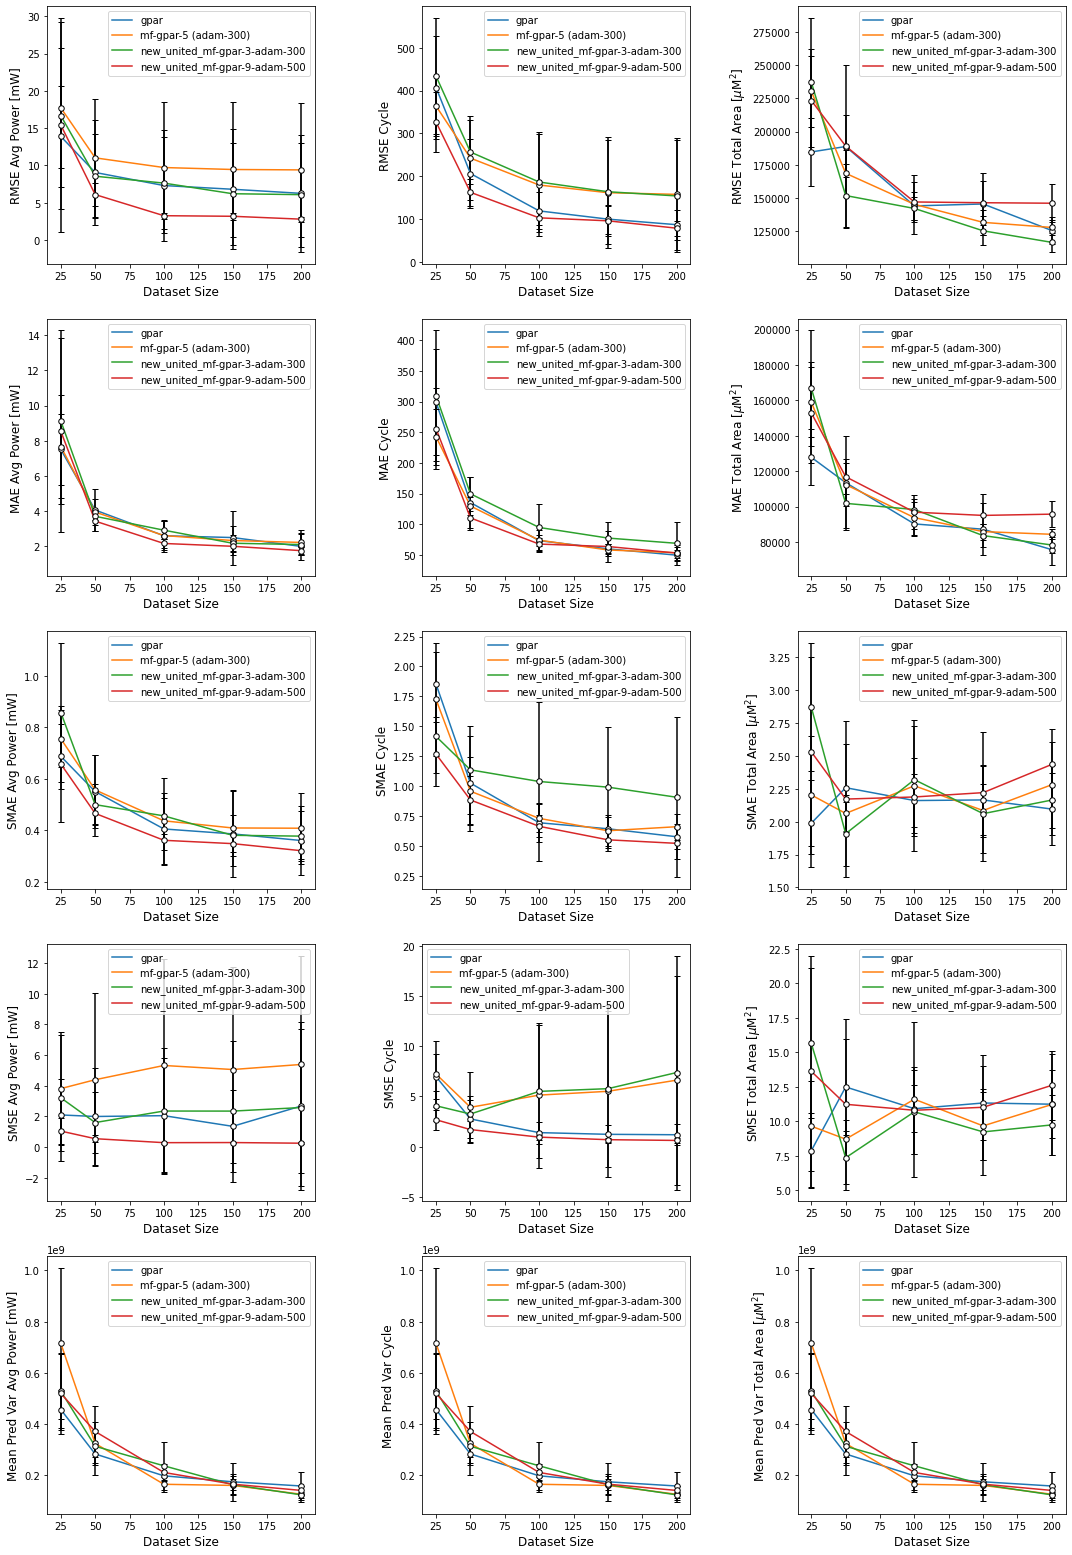

In [21]:
plot_model_stats(fft_stats,
                 task="fft",
                 save_name="model_comparison",
                 outputs=["avg_power", "cycle", "total_area"],
                 sizes=[25, 50, 100, 150, 200])

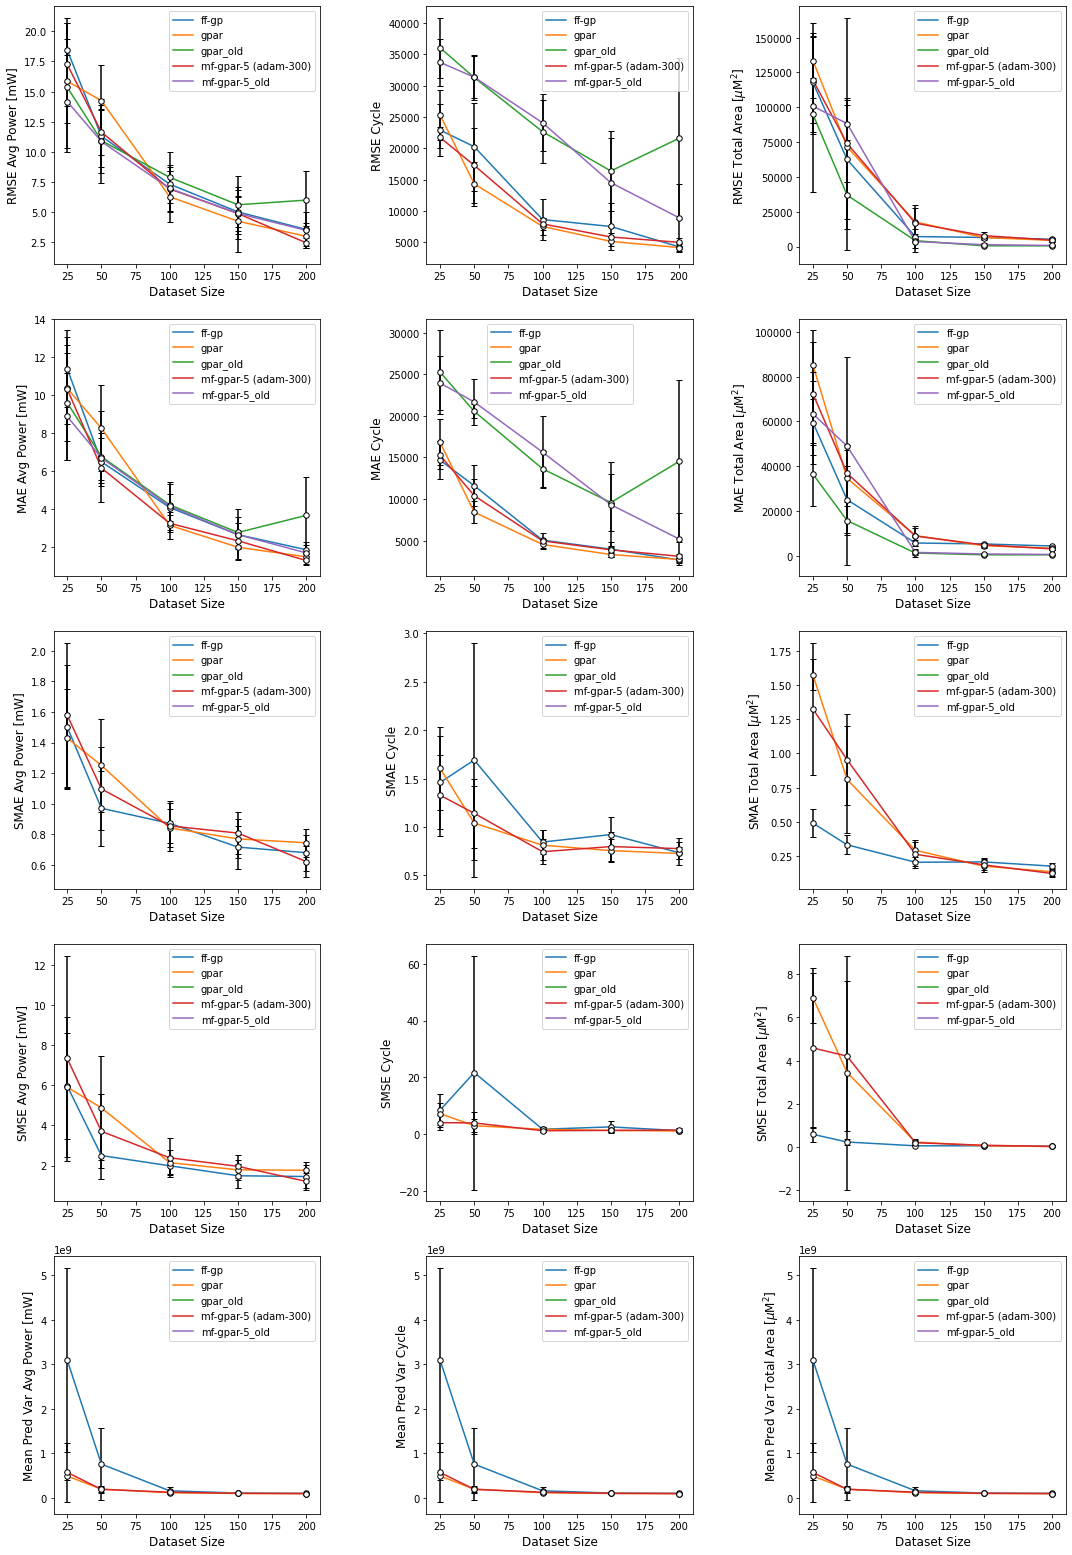

In [426]:
plot_model_stats(stencil3d_stats,
                 task="stencil3d",
                 save_name="model_comparison",
                 outputs=["avg_power", "cycle", "total_area"])

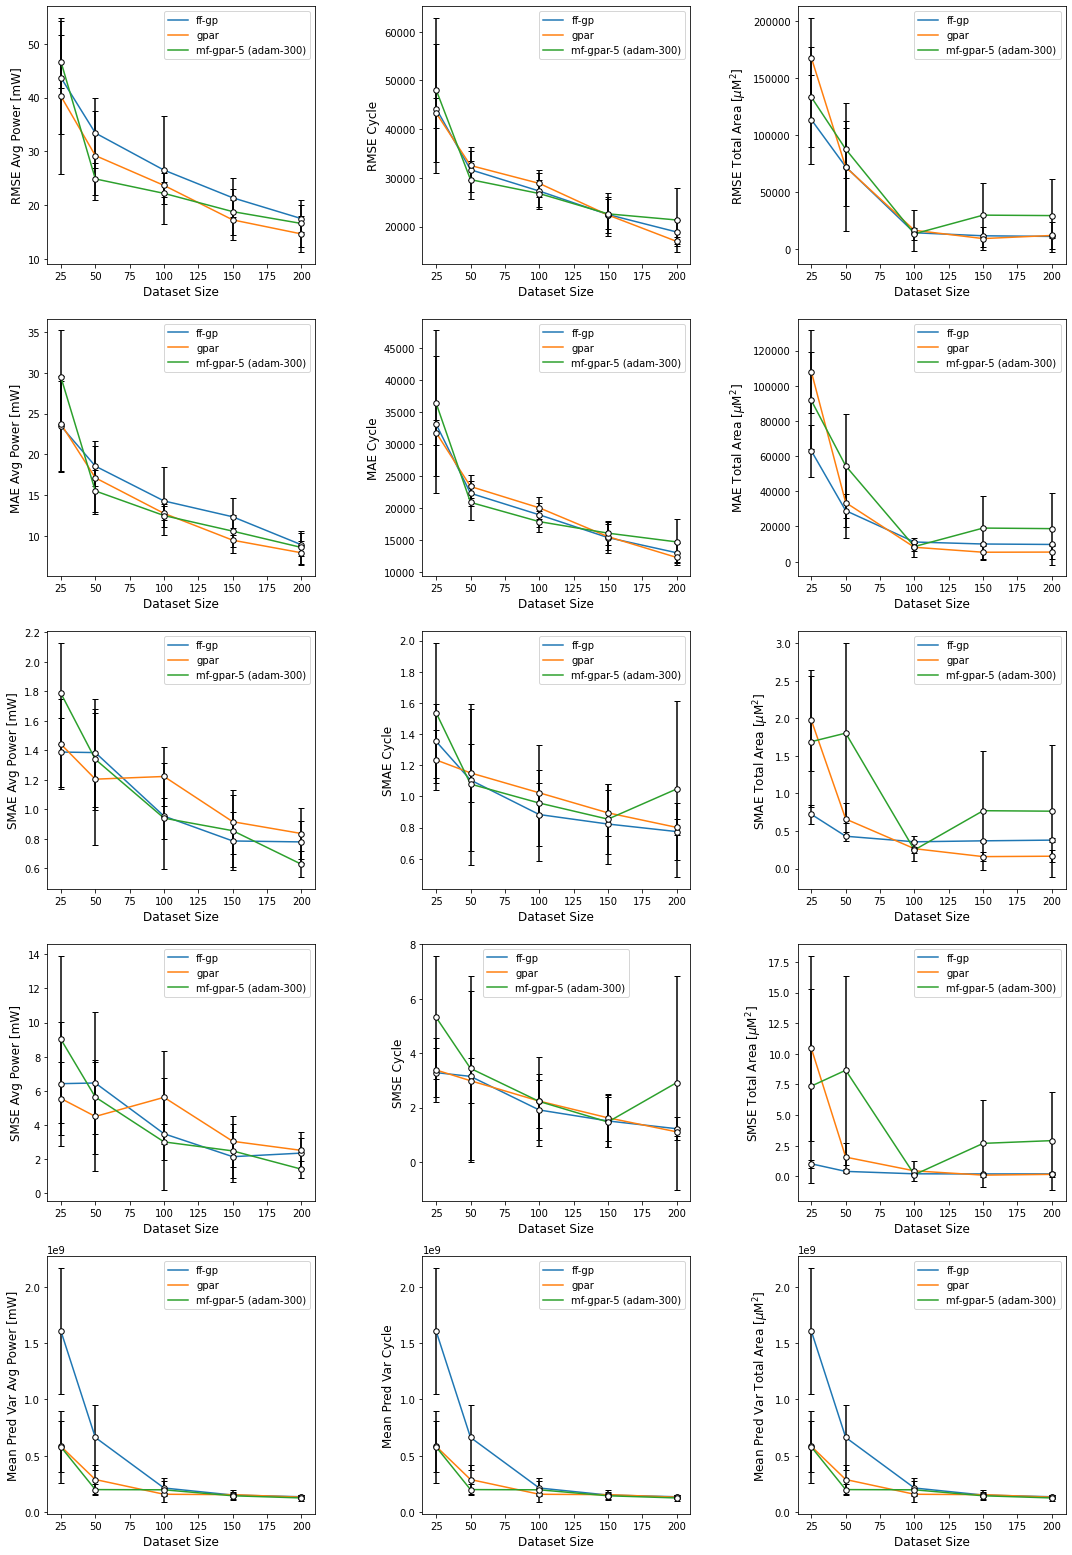

In [427]:
plot_model_stats(gemm_stats,
                 task="gemm",
                 save_name="model_comparison",
                 outputs=["avg_power", "cycle", "total_area"])

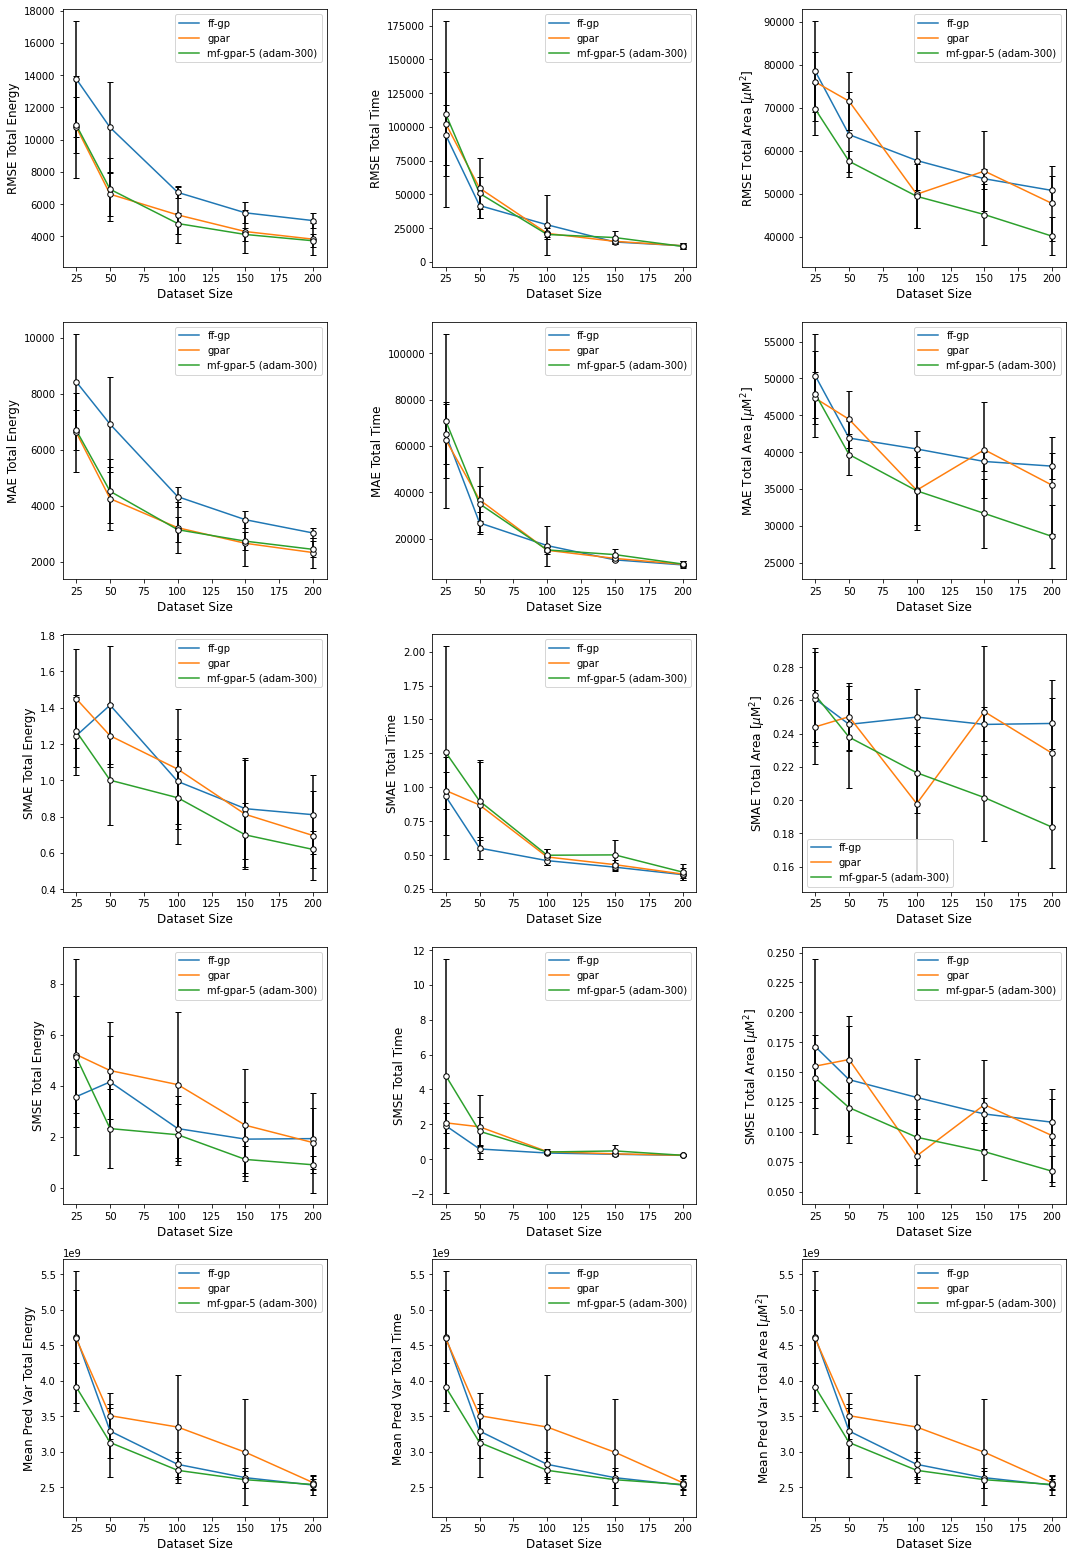

In [428]:
plot_model_stats(smaug_stats,
                 task="smaug",
                 save_name="model_comparison",
                 outputs=["total_energy", "total_time", "total_area"])